In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results/single_model_profs_new_metrics')
print HOME

/Users/cusgadmin/Desktop/plots-model-comp-paper/results/single_model_profs_new_metrics


In [207]:
import unicodedata
        
def cache_extractions(FN, timestamps=False):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["client_metrics"][0]["all_metrics"]
    result = {}
    for i in range(len(all_metrics)):
        data_lists = all_metrics[i]["data_lists"]
        for item in data_lists:
            key = item.keys()[0]
            key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
            if result.get(key) == None:
                result[key] = []
            if timestamps:
                data = item[key]["items"]
                data = { k: v for d in data for k, v in d.items() } # consolidate list of dicts
                value = np.concatenate([np.transpose([data.keys()]), np.transpose([data.values()])], axis = 1).astype(float)
            else:
                print np.asarray(item[key]["items"])
                value = np.asarray(item[key]["items"]).astype(float)
                value = np.concatenate([np.transpose([np.arange(len(value))]), np.transpose([value])], axis = 1).astype(float)
            result[key].append(value)
    batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    for key, value in result.iteritems():
        result[key] = np.concatenate(value)
    str_lats = d["client_metrics"][0]["all_lats"]
    import ast
    lats = [ast.literal_eval(x) for x in str_lats]
    hollistic_data = {}
    hollistic_data["e2e_lats"] = np.asarray(lats).flatten()
    hollistic_data["p99_lats"] = d["client_metrics"][0]["p99_lats"]
    hollistic_data["e2e_thrus"] = d["client_metrics"][0]["thrus"]
    
    return result, hollistic_data

resnet_models = [
    "tf-resnet-feats"
]

resnet4, resnet_hollistic4 = cache_extractions(HOME+"/"+"results-180219_175100.json", timestamps = True)
resnet4_exp, resnet_hollistic4_exp = cache_extractions(HOME+"/"+"results-180220_222906.json", timestamps = True)
resnet32, resnet_hollistic32 = cache_extractions(HOME+"/"+"results-180220_043817.json", timestamps = True)
resnet4_undersaturated, resnet_hollistic4_undersaturated = cache_extractions(HOME+"/"+"results-180221_011101.json", timestamps = True)
# 1/0.02363753667

def clean_and_remove_quarter(cache_extraction):
    # taking off the first 25% of the records to be sure the warmup time is removed
    for key, value in cache_extraction.iteritems():
        sorted_timestamps = np.argsort(value[:,0])
        value = value[sorted_timestamps] # sort data by timestamps
        cache_extraction[key] = value[value.shape[0]*0:] # cut off the first fourth from warmup effects

clean_and_remove_quarter(resnet4)
clean_and_remove_quarter(resnet4_exp)
clean_and_remove_quarter(resnet32)
clean_and_remove_quarter(resnet4_undersaturated)
    
for key, value in resnet4_exp.iteritems():
    print key, value.shape

model:tf-resnet-feats:1:prediction_latencies_list (10153, 2)
tf-resnet-feats:1:queue_sizes (50084, 2)
tf-resnet-feats:processing_latency (10152, 2)
tf-resnet-feats:1:processing_outs (23759, 2)
tf-resnet-feats:1:queue_arrivals (39936, 2)
app:tf-resnet-feats:prediction_latencies (38836, 2)


In [139]:
import seaborn as sns

def smoothLineHistogram(data, rug=False, label=None):
    sns.distplot(data, rug=rug, label=label)

def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        smoothLineHistogram(processing_time, label="Processing time")
        smoothLineHistogram(serving_time, label="Processing + Queueing time")
    plt.legend()

def compare_latency_dists_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        processing_time_timestamps = cached_extractions[model+":processing_latency"][:,0]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        serving_time_timestamps = cached_extractions["app:"+model+":prediction_latencies"][:,0]
        plt.title(model+" Processing Latency")
        plt.xlabel("timestamp since begining of experiment)")
        plt.ylabel("Latency (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(processing_time),np.min(serving_time)), max(np.max(processing_time),np.max(serving_time))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(processing_time_timestamps, processing_time, alpha = 0.15)
        plt.scatter(serving_time_timestamps, serving_time, alpha = 0.15)

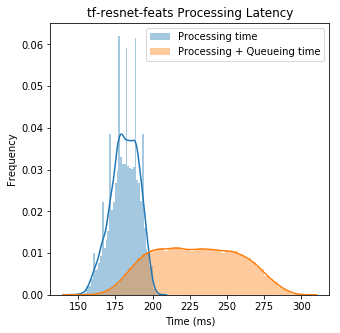

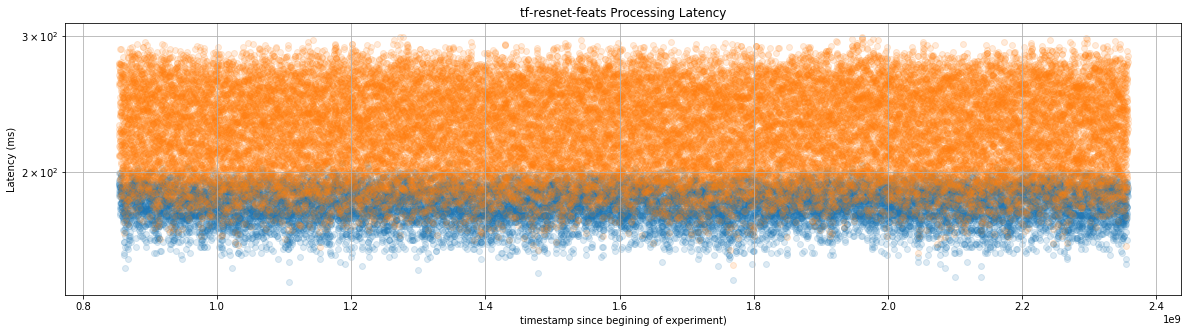

In [140]:
compare_latency_dists(resnet4_undersaturated, resnet_models)
compare_latency_dists_over_time(resnet4_undersaturated, resnet_models)

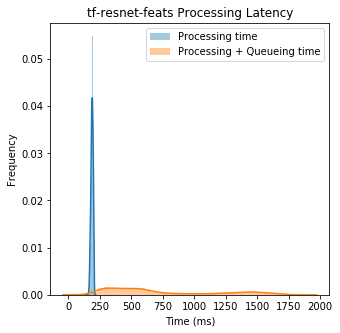

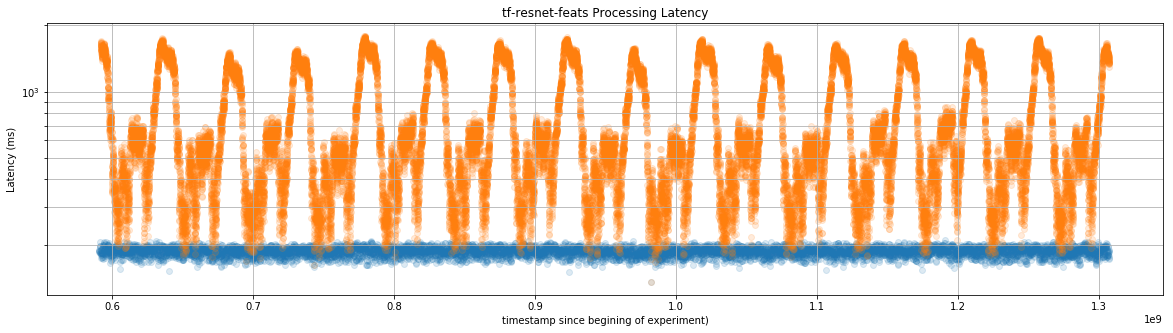

In [141]:
compare_latency_dists(resnet4_exp, resnet_models)
compare_latency_dists_over_time(resnet4_exp, resnet_models)

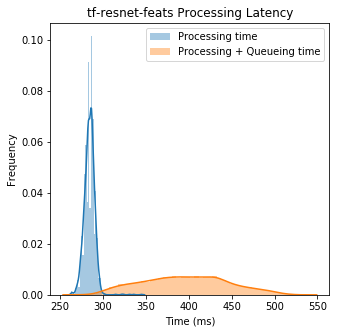

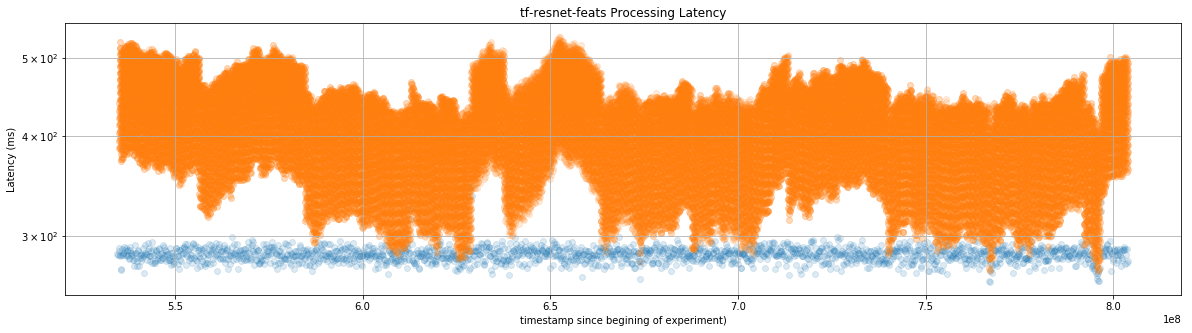

In [142]:
compare_latency_dists(resnet32, resnet_models)
compare_latency_dists_over_time(resnet32, resnet_models)

In [143]:
def get_arrival_intervals(cached_extractions, model, intra_batch_arrivals):
    arrivals = cached_extractions[model+":1:queue_arrivals"][:,1]
    timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = arrivals[1:] - arrivals[:-1]
    intervals = intervals/1000 # to ms
    if not intra_batch_arrivals:
        minimum_processing_time = np.min(cached_extractions[model+":processing_latency"][:,1])
        MIN = 2.5
        if minimum_processing_time < MIN:
            print "{model} processing time is too low (<{MIN}ms) to acceptably discern inter and intra batch arrivals".format(model=model, MIN=MIN)
            return intervals, timestamps # minimum processing time too close to the cut off, might be getting rid of inter-batch arrivals
        cutoff = MIN
        assert len(intervals) == len(timestamps)
        num_below = np.sum((intervals < cutoff).astype(int))
        above_mask = intervals >= cutoff
        intervals = intervals[above_mask]
        timestamps = timestamps[above_mask]
        print "{model}: Removed {num} points below {time} ms".format(model=model, num=num_below, time=cutoff)
    return intervals, timestamps
    
def get_outs_intervals(cached_extractions, model):
    outs = cached_extractions[model+":1:processing_outs"][:,1]
    timestamps = cached_extractions[model+":1:processing_outs"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = outs[1:] - outs[:-1]
    intervals = intervals/1000 # to ms
    return intervals, timestamps
    
def plot_inter_arrival(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time")
    plt.xlabel("Inter-arrival time (ms)")
    plt.ylabel("Frequency")
    for model in model_list:
        arrival_intervals, _ = get_arrival_intervals(cached_extractions, model, intra_batch_arrivals)
        outs_intervals, _ = get_outs_intervals(cached_extractions, model)
        arrival_CV = np.square(np.std(arrival_intervals)/np.mean(arrival_intervals))
        outs_CV = np.square(np.std(outs_intervals)/np.mean(outs_intervals))
        smoothLineHistogram(arrival_intervals, label=model+str(" arrival CV="+str(arrival_CV)))
        smoothLineHistogram(outs_intervals, label=model+str(" outs CV="+str(outs_CV)))
    plt.legend()
    plt.show()

def plot_inter_arrival_over_time(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        arrival_intervals, arrival_timestamps = get_arrival_intervals(cached_extractions, model, intra_batch_arrivals)
        arrival_CV = np.square(np.std(arrival_intervals)/np.mean(arrival_intervals))
        outs_intervals, outs_timestamps = get_outs_intervals(cached_extractions, model)
        outs_CV = np.square(np.std(outs_intervals)/np.mean(outs_intervals))
        plt.title(model+" Inter-arrival time")
        plt.xlabel("Position")
        plt.ylabel("Inter-arrival time (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(arrival_intervals),np.min(outs_intervals)), max(np.max(arrival_intervals),np.max(outs_intervals))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(arrival_timestamps, arrival_intervals, label="arrival CV="+str(arrival_CV), alpha = 0.3)
        plt.scatter(outs_timestamps, outs_intervals, label="outs CV="+str(outs_CV), alpha = 0.3)
        plt.legend()
    plt.show()


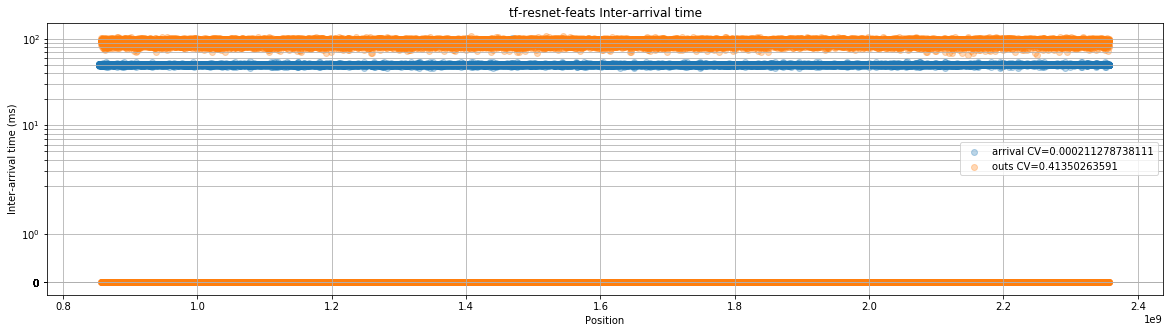

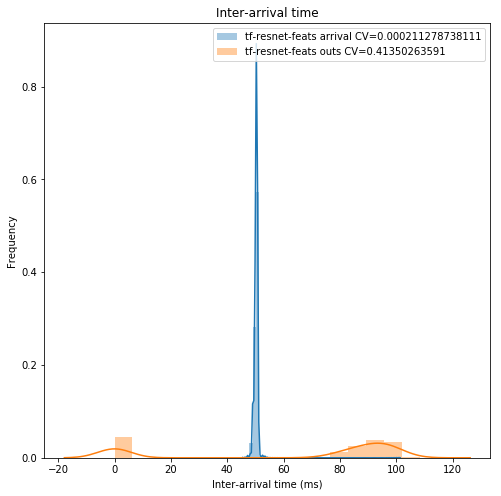

In [144]:
plot_inter_arrival_over_time(resnet4_undersaturated, resnet_models, intra_batch_arrivals=True)
plot_inter_arrival(resnet4_undersaturated, resnet_models, intra_batch_arrivals=True)

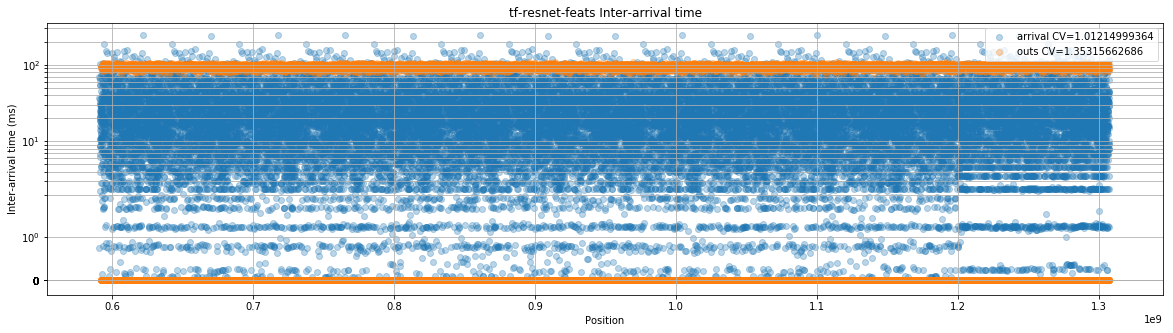

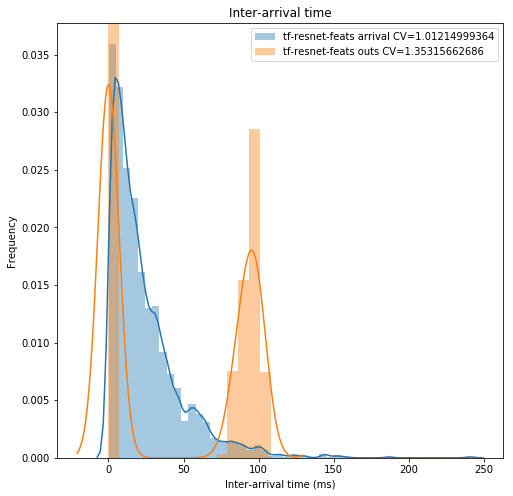

In [145]:
plot_inter_arrival_over_time(resnet4_exp, resnet_models, intra_batch_arrivals=True)
plot_inter_arrival(resnet4_exp, resnet_models, intra_batch_arrivals=True)

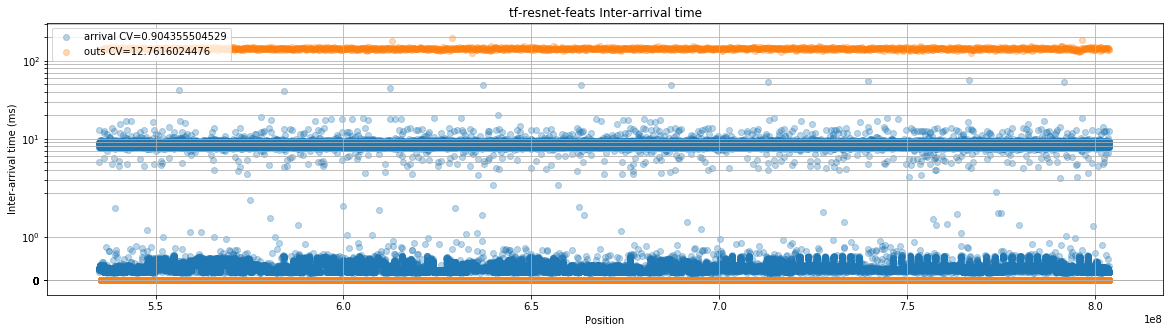

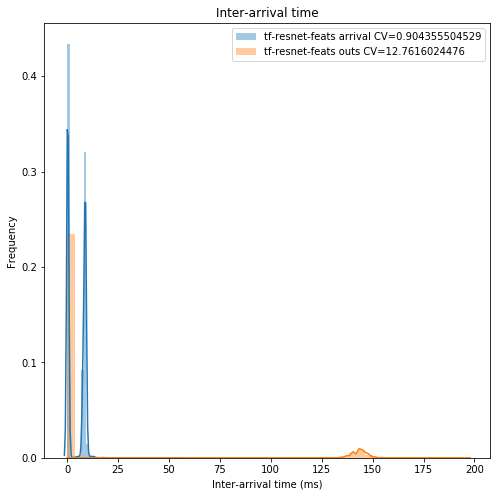

In [146]:
plot_inter_arrival_over_time(resnet32, resnet_models, intra_batch_arrivals=True)
plot_inter_arrival(resnet32, resnet_models, intra_batch_arrivals=True)

In [299]:
def arrival_curve_and_out_data(cached_extractions, model, trial_range):
    arrival_timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
    outs_timestamps = cached_extractions[model+":1:processing_outs"][:,0]
    print len(arrival_timestamps), len(outs_timestamps)
    def get_smallest_delta_1(k, timestamps):
        current_delta = timestamps[k-1] - timestamps[0]
        min_so_far = current_delta
        best_index = k-1
        for index in xrange(k - 1, len(timestamps)-1):
            delta_in = timestamps[index + 1] - timestamps[index]
            delta_out = timestamps[index-(k-1)+1] - timestamps[index-(k-1)]
            next_delta = current_delta - delta_out + delta_in
            if next_delta < min_so_far:
                best_index = index
                min_so_far = next_delta
            current_delta = next_delta
        return min_so_far
    def get_smallest_delta_2(time_range, timestamps):
        head_index = 0 # the first index less than or equal to time_range's higher end
        tail_index = 0 # the first index less than or equal to time_range's lower end
        position = 'tail' # start when time_range's lower end (tail) is aligned with a point
        contained_currently = 1 # a single point (the first index) must be contained in the time_range
        # add the rest of the timepoints contained in time_range
        for i in xrange(tail_index+1, len(timestamps)):
            if timestamps[i] <= timestamps[tail_index] + time_range:
                contained_currently+=1
                head_index+=1
            else:
                break
        max_so_far = contained_currently
        while head_index < len(timestamps)-1: # this means time_range's higher end hasn't exceeded the very last timestamp
            if position == "tail":
                head_time_position = timestamps[tail_index] + time_range
                head_delta = timestamps[head_index+1] - head_time_position
                assert head_delta >= 0
                tail_delta = timestamps[tail_index+1] - timestamps[tail_index]
            elif position == "head":
                tail_time_position = timestamps[head_index] - time_range
                tail_delta = timestamps[tail_index+1] - tail_time_position
                assert tail_delta >= 0
                head_delta = timestamps[head_index+1] - timestamps[head_index]
            if tail_delta < head_delta:
                position = "tail"
                tail_index = tail_index + 1 # head_index stays the same
                if tail_delta > 1e-8: # means the previous tail_index is no longer within the time_range
                    contained_currently-=1
            elif head_delta <= tail_delta:
                position = "head"
                head_index = head_index + 1 # tail_index stays the same
                contained_currently+=1
            assert contained_currently >= head_index-tail_index
            if contained_currently > max_so_far:
                max_so_far = contained_currently
                best_config = tail_index, head_index, position, contained_currently
        print best_config
        return max_so_far
#     arrival_x_axis = np.asarray([get_smallest_delta_1(i, arrival_timestamps) for i in trial_range])
#     arrival_y_axis = trial_range
#     outs_x_axis = np.asarray([get_smallest_delta_1(i, outs_timestamps) for i in trial_range])
#     outs_y_axis = trial_range
    arrival_y_axis = np.asarray([get_smallest_delta_2(i*1000, arrival_timestamps) for i in trial_range])
    arrival_x_axis = np.asarray(list(trial_range)) # converting to ms
    outs_y_axis = np.asarray([get_smallest_delta_2(i*1000, outs_timestamps) for i in trial_range])
    outs_x_axis = np.asarray(list(trial_range)) # converting to ms
    return arrival_x_axis, arrival_y_axis, outs_x_axis, outs_y_axis

def plot_arrival_and_out_curves(cached_extractions, model_list, N=xrange(1,50+1)):
    plt.figure(figsize=(8,8))
    plt.title("Arrival curves")
    plt.xlabel("time-delta in ms")
    plt.ylabel("Queries")
    import itertools
    colors = itertools.cycle(('blue', 'orange', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'grey'))
    for model in model_list:
        arrival_x_data, arrival_y_data, outs_x_data, outs_y_data = arrival_curve_and_out_data(cached_extractions, model, N)
        color = colors.next()
        plt.plot(arrival_x_data, arrival_y_data, color = "blue", linestyle="--", label=model+" arrival curve")
        plt.plot(outs_x_data, outs_y_data, color = "blue", label=model+" service curve")
    plt.legend()
#     y_jump = 1
#     max_N = max(N)
#     while max_N/y_jump > 30:
#         y_jump*=2
#     plt.yticks(np.arange(0, max_N+1, y_jump))
    plt.grid(True)
    plt.show()

[ 1283893.205  1283916.773  1283941.516  1283964.994  1283988.693
  1284012.202  1284035.853  1284059.476  1284084.377  1284108.103
  1284131.681  1284155.349  1284178.949  1284202.67   1284227.346
  1284250.92   1284274.662  1284298.202  1284321.845  1284345.431
  1284370.264  1284393.835  1284417.443  1284441.087  1284464.739
  1284488.304  1284513.08   1284539.022  1284560.308  1284583.909
  1284607.519  1284631.118  1284655.013  1284679.748  1284703.35
  1284726.966  1284750.752  1284774.324  1284797.93   1284821.68
  1284846.395  1284870.01   1284893.643  1284917.387  1284941.002
  1284964.604  1284989.318  1285013.464  1285036.617  1285060.247
  1285083.839  1285107.46   1285132.189  1285155.823  1285179.392
  1285203.058  1285226.669  1285250.274  1285275.044  1285298.737
  1285322.34   1285345.901  1285369.553  1285393.202  1285417.891
  1285441.516  1285464.995]
39898 23907
(39620, 39684, 'head', 91)
(0, 68, 'head', 69)
(2095, 2144, 'head', 50)
(3340, 3392, 'head', 53)


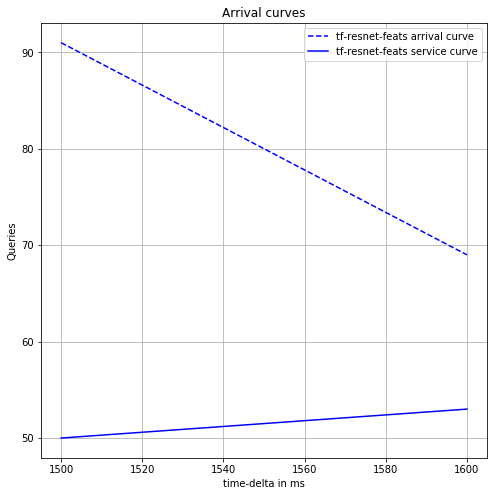

In [300]:
arrivals = resnet4["tf-resnet-feats"+":1:queue_arrivals"][:,0]
start = 39617
end = 39684
print (arrivals[start:end])/1000.
plot_arrival_and_out_curves(resnet4, resnet_models, N=[1500, 1600])

39936 23759
(656, 659, 'head', 4)
(622, 625, 'head', 4)
(14617, 14620, 'head', 5)
(28610, 28614, 'head', 6)
(34607, 34611, 'head', 6)
(4619, 4624, 'head', 6)
(620, 625, 'head', 6)
(36605, 36610, 'head', 10)
(620, 625, 'head', 6)
(28609, 28614, 'head', 8)
(32607, 32612, 'head', 8)
(36546, 36551, 'head', 11)
(560, 565, 'head', 6)
(34546, 34551, 'head', 8)
(4619, 4625, 'head', 7)
(34606, 34612, 'head', 9)
(12616, 12622, 'head', 9)
(38603, 38609, 'head', 11)
(620, 626, 'head', 7)
(27634, 27640, 'head', 8)
(5644, 5650, 'head', 8)
(25634, 25640, 'head', 10)
(170, 176, 'head', 7)
(15639, 15645, 'head', 9)
(32157, 32163, 'head', 10)
(28159, 28165, 'head', 10)
(39292, 39298, 'head', 10)
(18613, 18620, 'head', 9)
(620, 627, 'head', 8)
(34606, 34613, 'head', 13)
(25633, 25640, 'head', 12)
(13639, 13646, 'head', 9)
(102, 109, 'head', 8)
(29164, 29171, 'head', 10)
(13171, 13178, 'head', 9)
(37545, 37552, 'head', 12)
(102, 109, 'head', 8)
(5173, 5181, 'head', 9)
(1174, 1182, 'head', 9)
(25163, 25171

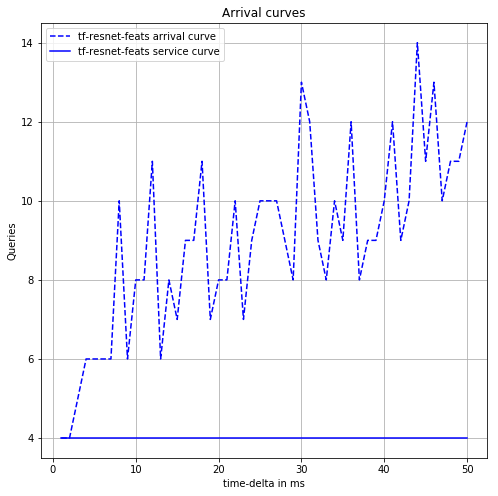

In [287]:
plot_arrival_and_out_curves(resnet4_exp, resnet_models)

79651 34268


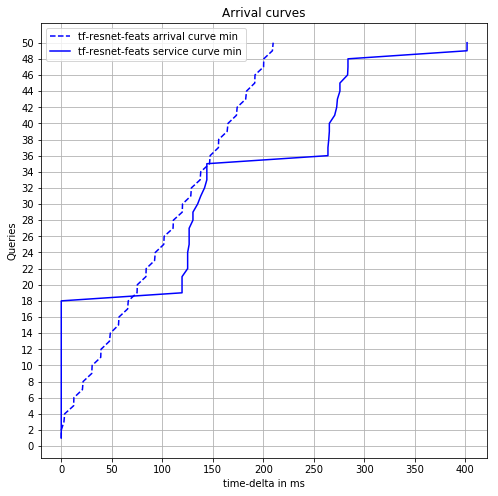

In [210]:
plot_arrival_and_out_curves(resnet32, resnet_models)

In [36]:
def plot_queue_sizes(cached_extractions, model_list, log=False):
    plt.figure(figsize=(8,8))
    plt.title("Queue length")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    if log:
        plt.xscale("log")
    for model in model_list:
        sizes = cached_extractions[model+":1:queue_sizes"]
        plt.hist(sizes, label=model,alpha=0.3)
    plt.legend()
    
def plot_ordinal_queue_sizes(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions[model+":1:queue_sizes"][:,1]
        timestamps = cached_extractions[model+":1:queue_sizes"][:,0]
        plt.title(model+" Queue length")
        plt.xlabel("Position")
        plt.ylabel("Length")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, sizes, label=model, alpha = 0.3)

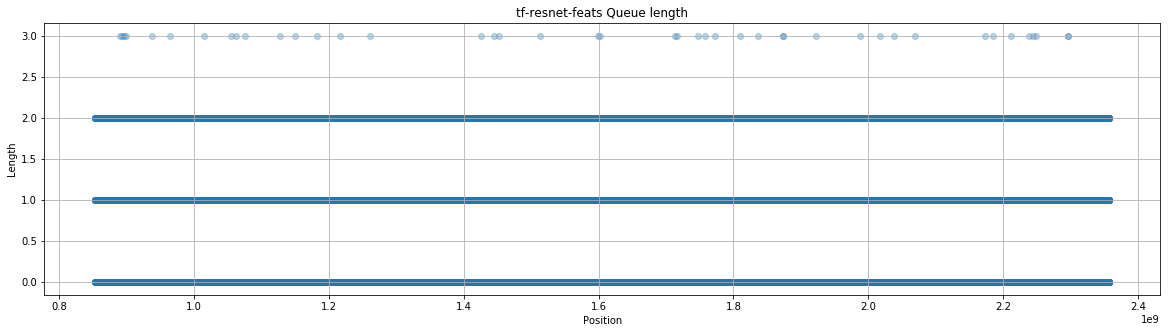

In [173]:
plot_ordinal_queue_sizes(resnet4_undersaturated, resnet_models)

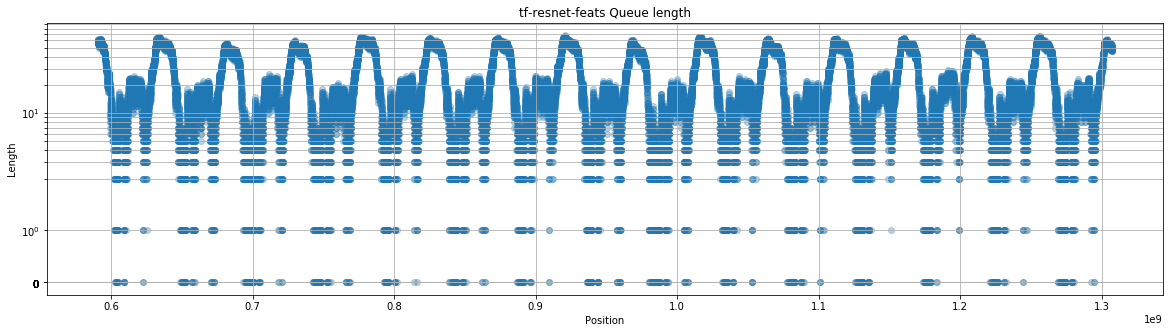

In [45]:
plot_ordinal_queue_sizes(resnet4_exp, resnet_models)

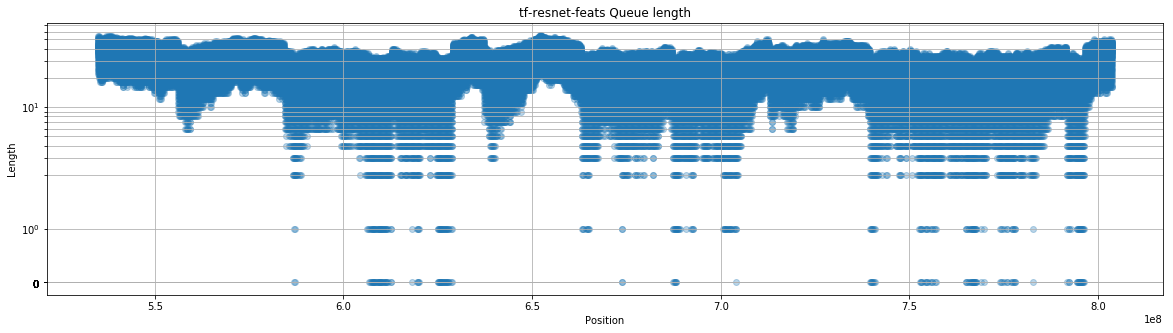

In [38]:
plot_ordinal_queue_sizes(resnet32, resnet_models)

In [69]:
def plot_e2e_lats(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Latencies")
    lats = cached_extractions["e2e_lats"]
    plt.plot(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', )
    plt.ylabel("Latency (ms)")

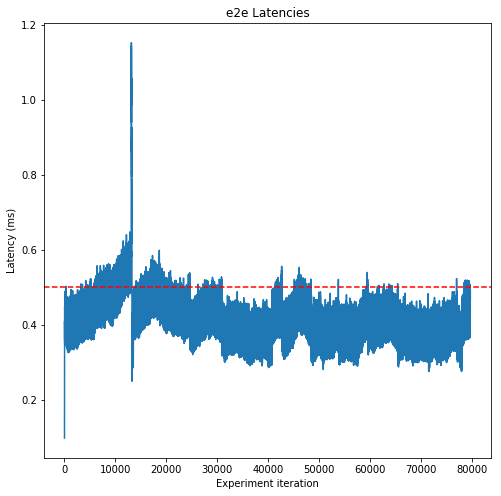

In [99]:
plot_e2e_lats(resnet_hollistic)

In [100]:
plot_mean_batch_sizes(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("Mean effective batchsizes")
    lats = cached_extractions["e2e_lats"]
    plt.plot(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', )
    plt.ylabel("Latency (ms)")

SyntaxError: invalid syntax (<ipython-input-100-594836f26b0a>, line 1)